### Apply Cutmix


**CutMix** is a data augmentation technique used in computer vision. Instead of only mixing images or labels, CutMix cuts a rectangular patch from one image and pastes it onto another image. The labels of the two images are also mixed in proportion to the area of the patch.

This helps the model learn from both images at the same time, improves generalization, and makes the model less likely to overfit.

---

👉 Example:

* Take **Image A** and **Image B**.
* Cut a patch from Image B and paste it into Image A.
* The final label = (1 − patch area ratio) × Label A + (patch area ratio) × Label B.

---


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

def create_flowers_meta_df(file_dir):
    paths = []  # list of image file paths
    labels = [] # flower categories
    
    # Use os.walk() to traverse all subdirectories under the given directory. 
    # In "kaggle/input/flowers-dataset", all files with ".jpg" extension are image files.
    # Subdirectories exist under "kaggle/input/flowers-dataset".
    for dirname, _, filenames in os.walk(file_dir):
        for filename in filenames:
            # Some files in the directory are not images.
            if '.jpg' in filename:
                # Get the absolute file path and append it to the paths list.
                file_path = dirname + '/' + filename
                paths.append(file_path)
                
                # Assign labels based on the folder name in the file path
                # (daisy, dandelion, roses, sunflowers, tulips).
                if 'daisy' in file_path:
                    labels.append('daisy')
                elif 'dandelion' in file_path:
                    labels.append('dandelion')
                elif 'roses' in file_path:
                    labels.append('rose')
                elif 'sunflowers' in file_path:
                    labels.append('sunflowers')
                elif 'tulips' in file_path:
                    labels.append('tulips')
    
    # Create a metadata DataFrame containing file paths and labels.
    data_df = pd.DataFrame({'path': paths, 
                            'label': labels})
    
    # Map string labels to numeric target values.
    label_mapping = {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflowers': 3, 'tulips': 4}
    data_df['target'] = data_df['label'].map(label_mapping)

    return data_df


In [2]:
from sklearn.model_selection import train_test_split

data_df = create_flowers_meta_df('/kaggle/input/')  # /kaggle/input/flowers-dataset

# Split the full dataset into training (70% of the total) and testing (30% of the total).
train_df, test_df = train_test_split(data_df, test_size=0.3, stratify=data_df['target'], random_state=2025)

# Further split the training DataFrame into training and validation sets.
# 80% of train_df is used for training, and 20% is used for validation.
tr_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['target'], random_state=2025)

print(data_df.shape, train_df.shape, tr_df.shape, val_df.shape, test_df.shape)


(3670, 3) (2569, 3) (2055, 3) (514, 3) (1101, 3)


### Create DataLoader

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from PIL import Image

class FlowerDataset(Dataset):
    # Accepts arguments such as image file paths, target labels, and transforms 
    # required for preprocessing image and target data.
    def __init__(self, image_paths, targets=None, transform=None):
        self.image_paths = image_paths
        self.targets = targets
        self.transform = transform
    
    # Return the total number of samples
    def __len__(self):
        return len(self.image_paths)
        
    # Return a single image and label as tensors for the given idx
    def __getitem__(self, idx):    
        # Load the image using PIL and return a PIL Image object.
        pil_image = Image.open(self.image_paths[idx])
        # Usually transform is not None (at least a Tensor conversion is applied).
        image = self.transform(pil_image)

        if self.targets is not None:
            # Convert the individual target value into a tensor.
            target = torch.tensor(self.targets[idx])
            return image, target
        # For test data, targets may not be provided, so handle that case.
        else:
            return image


In [4]:
from torch.utils.data import DataLoader
from torchvision import transforms as T

BATCH_SIZE = 32

def create_tr_val_loader(tr_df, val_df, transform):
    tr_dataset = FlowerDataset(image_paths=tr_df['path'].to_list(), 
                            targets=tr_df['target'].to_list(), transform=transform)
    val_dataset = FlowerDataset(image_paths=val_df['path'].to_list(), 
                            targets=val_df['target'].to_list(), transform=transform)
    
    tr_loader = DataLoader(tr_dataset, batch_size = BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=2*BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

    return tr_loader, val_loader

In [5]:
IMG_SIZE = 224
IMG_MEANS = [0.485, 0.456, 0.406] 
IMG_STD = [0.229, 0.224, 0.225] 

train_transform = T.Compose([
            T.Resize(size=(IMG_SIZE, IMG_SIZE)),
            T.ToTensor(), T.Normalize(mean=IMG_MEANS, std=IMG_STD)
])

tr_loader, val_loader = create_tr_val_loader(tr_df=tr_df, val_df=val_df, transform=train_transform)
images, labels = next(iter(tr_loader))
print(images.shape, labels.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32])


### CutMix 시각화 해보기
* uniform 분포로 0 ~ 1 사이값을 추출하고 이를 기반으로 cut할 이미지 영역 계산.
* 원본 이미지에 cut 이미지 영역을 붙여 넣음. 

In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

def rand_bbox(size, lam):
    """Generate a bounding box for the cut region."""
    # For single image input and channel-first input
    W = size[1]  # width
    H = size[2]  # height
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.array(W * cut_rat).astype(np.int32)
    cut_h = np.array(H * cut_rat).astype(np.int32)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def cutmix_images(img1, img2, alpha=1.0):
    """Cut a region from img2 and paste it onto img1."""
    lam = np.random.beta(alpha, alpha)  # Extract a value between 0 ~ 1 from a uniform distribution
    bbx1, bby1, bbx2, bby2 = rand_bbox(img1.size(), lam)
    
    img1[:, bbx1:bbx2, bby1:bby2] = img2[:, bbx1:bbx2, bby1:bby2]
    # Calculate the exact area ratio of the pasted region, 
    # because boundaries may exceed the image and deviate from the lambda ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (img1.size(1) * img1.size(2)))
    
    print('cut w x h:', (bbx2-bbx1), (bby2-bby1), 'image w x h:', img1.size(1), img1.size(2))
    
    return img1, lam


In [7]:
alpha = 1.0
np.random.beta(alpha, alpha)

0.3327425849266214

In [8]:
import pandas as pd

# Set the maximum column width to None (display all content)
pd.set_option('display.max_colwidth', None)

print(data_df[data_df['label'] == 'daisy']['path'].iloc[:2])
print(data_df[data_df['label'] == 'rose']['path'].iloc[:2])

1597     /kaggle/input/flowers-dataset/flower_photos/daisy/8882282142_9be2524d38_m.jpg
1598    /kaggle/input/flowers-dataset/flower_photos/daisy/19280272025_57de24e940_m.jpg
Name: path, dtype: object
2230      /kaggle/input/flowers-dataset/flower_photos/roses/6108118824_5b0231a56d.jpg
2231    /kaggle/input/flowers-dataset/flower_photos/roses/2265390547_2409007cef_n.jpg
Name: path, dtype: object


In [9]:
from torchvision import transforms as T

transform = T.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

daisy_img = Image.open('/kaggle/input/flowers-dataset/flower_photos/daisy/8882282142_9be2524d38_m.jpg')
rose_img = Image.open('/kaggle/input/flowers-dataset/flower_photos/roses/6108118824_5b0231a56d.jpg')

daisy_img_t = transform(daisy_img)
rose_img_t = transform(rose_img)

cutmix_img, lam = cutmix_images(daisy_img_t, rose_img_t)
print(type(cutmix_img), cutmix_img.shape, 'lam:', lam)

cut w x h: 135 113 image w x h: 224 224
<class 'torch.Tensor'> torch.Size([3, 224, 224]) lam: 0.6959701849489797


(-0.5, 223.5, 223.5, -0.5)

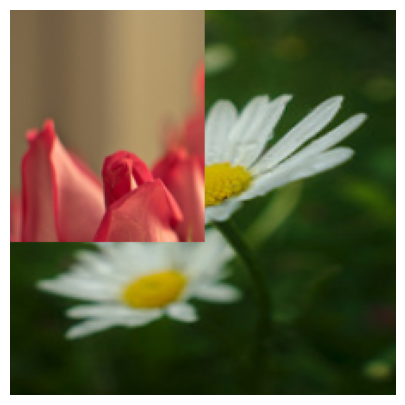

In [10]:
cutmix_img_np = cutmix_img.permute(1, 2, 0).numpy()

plt.figure(figsize=(10, 5))
plt.imshow(cutmix_img_np) # matplotlib.pyplot.imshow: Channel Last
plt.axis('off')

### Applying CutMix to Images and Target Values in a Batch


In [11]:
torch.randperm(32)


tensor([22, 16, 31, 28, 30, 25,  2,  9,  7,  3, 10, 15, 17,  5, 13, 18,  0, 12,
        26, 14, 29, 23, 11,  4, 24, 21, 20,  1,  8, 27,  6, 19])

In [12]:
import numpy as np
import torch

def rand_bbox(size, lam):
    # Input size includes batch dimension (4D tensor). 
    # The format is channel-first (N, C, W, H).
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.array(W * cut_rat).astype(np.int32)
    cut_h = np.array(H * cut_rat).astype(np.int32)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    # Apply clipping to ensure values are at least 0 and do not exceed W or H.
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def cutmix(images, targets, alpha=1.0, verbose=False):
    """
    Args:
        images (Tensor): batch of images.
        target (Tensor): batch of labels.
        alpha (float): alpha parameter for the Beta distribution.
        
    Returns:
        Tuple[Tensor, Tensor, float]: CutMix-applied images, updated targets, and lambda.
    """
    # Randomly shuffle indices according to the batch size
    indices = torch.randperm(images.size(0))
    shuffled_images = images[indices]
    shuffled_targets = targets[indices]
    
    lam = np.random.beta(alpha, alpha)
    # Extract the bounding box area to cut. The same bbox area is used across the batch.
    bbx1, bby1, bbx2, bby2 = rand_bbox(images.size(), lam)
    images[:, :, bbx1:bbx2, bby1:bby2] = shuffled_images[:, :, bbx1:bbx2, bby1:bby2]
    # Recalculate lam based on the actual ratio of pixels cut compared to the full image.
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (images.size()[-1] * images.size()[-2]))
    if verbose:
        print('cut w x h:', (bbx2-bbx1), (bby2-bby1), (bbx2 - bbx1) * (bby2 - bby1), 
              'image w x h:', images.size()[-1], images.size()[-2], (images.size()[-1] * images.size()[-2]))

    return images, targets, shuffled_targets, lam


In [13]:
IMG_SIZE = 224
IMG_MEANS = [0.485, 0.456, 0.406] # Mean values per image channel from the ImageNet dataset
IMG_STD = [0.229, 0.224, 0.225]   # Standard deviation values per image channel from the ImageNet dataset

train_transform = T.Compose([
            T.Resize(size=(IMG_SIZE, IMG_SIZE)),
            T.ToTensor(), # Exclude Normalize() for visualization purposes
])

tr_loader, val_loader = create_tr_val_loader(tr_df=tr_df, val_df=val_df, transform=train_transform)

images, targets = next(iter(tr_loader))

cutmix_images, targets, shuffled_targets, lam = cutmix(images.clone(), targets.clone(), alpha=1.0, verbose=True)
print('targets:', targets, 'shuffled_targets:', shuffled_targets, 'lam:', lam )


cut w x h: 108 124 13392 image w x h: 224 224 50176
targets: tensor([1, 3, 3, 0, 1, 1, 2, 1, 0, 3, 3, 4, 4, 0, 3, 2, 1, 2, 4, 3, 0, 2, 2, 4,
        2, 1, 3, 0, 3, 1, 0, 2]) shuffled_targets: tensor([3, 0, 4, 0, 1, 1, 2, 3, 1, 3, 0, 2, 3, 1, 2, 4, 2, 1, 4, 3, 3, 2, 0, 4,
        1, 1, 3, 0, 2, 0, 2, 3]) lam: 0.7330994897959184


In [14]:
images_np = images.permute(0, 2, 3, 1).numpy()
cutmix_images_np = cutmix_images.permute(0, 2, 3, 1).numpy()

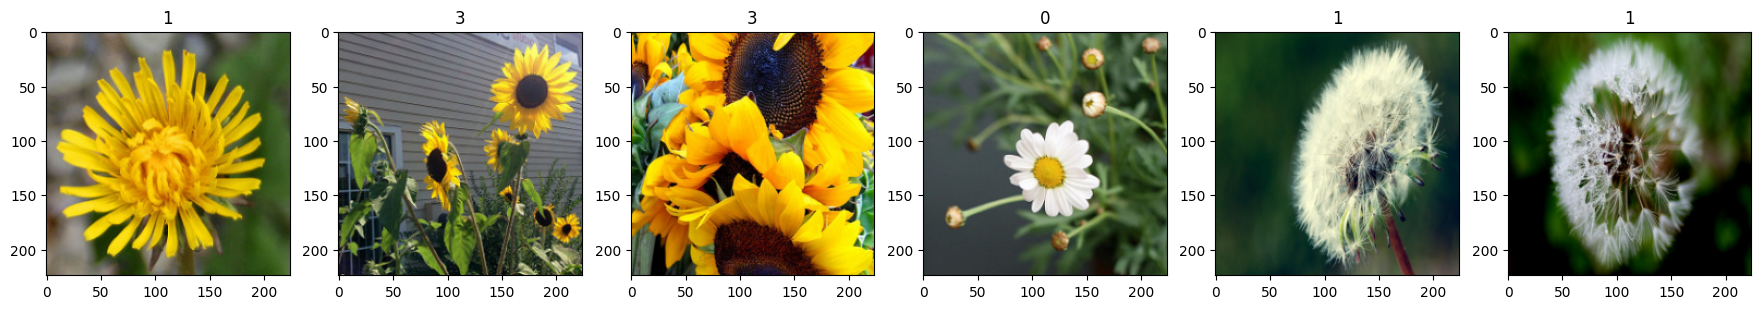

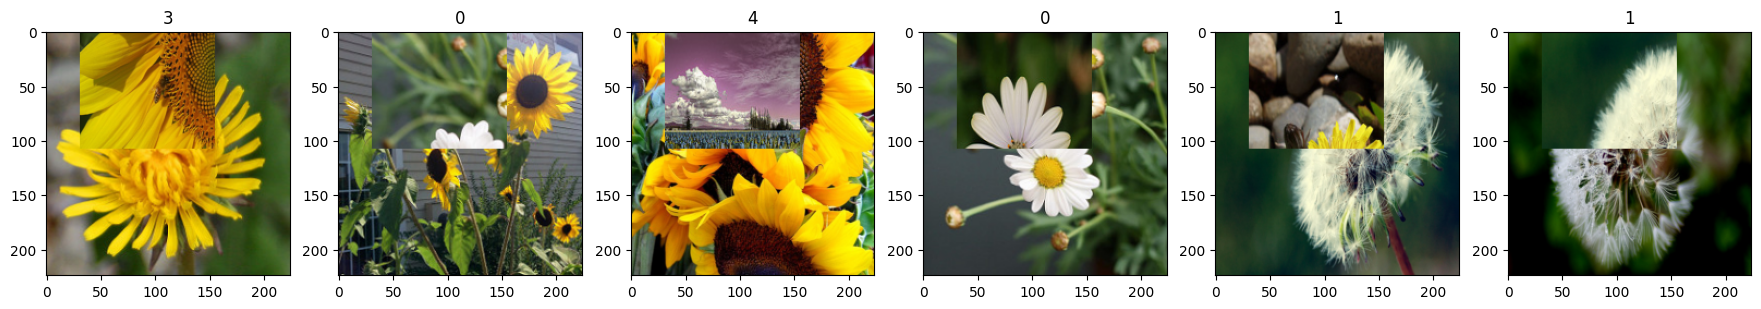

In [15]:
#'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflowers': 3, 'tulips': 4
def show_grid_images_np(images_np, targets_np, ncols=6):
    figure, axs = plt.subplots(figsize=(22, 6), nrows=1, ncols=ncols)
    for i in range(ncols):
        axs[i].imshow(images_np[i])
        axs[i].set_title(targets_np[i])
        
show_grid_images_np(images_np, targets.numpy(), ncols=6)
show_grid_images_np(cutmix_images_np, shuffled_targets.numpy(), ncols=6)

### Training and Evaluation with CutMix

* Create a torchvision pretrained ResNet-50 model
* Reconstruct the loss function in the training loop by reflecting the ratio of the cut image region


In [16]:
import torch
import torch.nn as nn
from torchvision import models

def create_resnet_model(model_name, num_classes=10, weights='DEFAULT'):
    model = None
    if model_name == 'resnet50':
        model = models.resnet50(weights=weights)
    elif model_name == 'resnet101':
        model = models.resnet101(weights=weights)
    
    num_in_features = model.fc.in_features
    model.fc = nn.Linear(in_features=num_in_features, out_features=num_classes)

    return model
    
resnet_model = create_resnet_model('resnet50', num_classes=5, weights='DEFAULT') #resnet50, resnet101

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 231MB/s]


### Creating and Applying the Trainer Class

* In the Trainer loop, when using CutMix, reconstruct the loss by considering the cut image region.
* Add a constructor argument `cutmix_proba`. If set to 1, always apply CutMix.


In [17]:
from tqdm import tqdm
import torch.nn.functional as F

class Trainer:
    def __init__(self, model, loss_fn, optimizer, train_loader, val_loader, scheduler=None, 
                 callbacks=None, cutmix_proba=0, device=None):
        self.model = model.to(device)
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        # Add scheduler
        self.scheduler = scheduler
        self.device = device
        # Track current learning rate
        self.current_lr = self.optimizer.param_groups[0]['lr']
        # Receive checkpoint and early stopping classes as a list
        self.callbacks = callbacks
        # Probability of applying CutMix
        self.cutmix_proba = cutmix_proba
        
    def train_epoch(self, epoch):
        self.model.train()

        # Running average loss
        accu_loss = 0.0
        running_avg_loss = 0.0
        # Accuracy tracking: total samples and number of correct predictions
        num_total = 0.0
        accu_num_correct = 0.0
        accuracy = 0.0
        # Visualize training progress in real time with tqdm
        with tqdm(total=len(self.train_loader), desc=f"Epoch {epoch+1} [Training..]", leave=True) as progress_bar:
            for batch_idx, (inputs, targets) in enumerate(self.train_loader):
                # Always use to(self.device), not to(device)
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)
                
                # If using CutMix, do forward pass and compute loss accordingly
                r = np.random.rand(1)
                if r < self.cutmix_proba: 
                    inputs, targets_a, targets_b, lam = cutmix(inputs, targets.clone(), alpha=1.0)
                    outputs = self.model(inputs)
                    loss = lam * self.loss_fn(outputs, targets_a) + (1 - lam) * self.loss_fn(outputs, targets_b)
                # Otherwise, standard forward pass and loss
                else:
                    outputs = self.model(inputs)
                    loss = self.loss_fn(outputs, targets)
                    
                # Backward pass
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                # Accumulate batch loss and compute running average loss
                accu_loss += loss.item()
                running_avg_loss = accu_loss /(batch_idx + 1)

                # Compute accuracy metric
                # Count matches between predicted classes and targets
                num_correct = (outputs.argmax(-1) == targets).sum().item()
                # Update cumulative totals and compute accuracy
                num_total += inputs.shape[0]
                accu_num_correct += num_correct
                accuracy = accu_num_correct / num_total

                # Update tqdm progress bar with running average loss and accuracy
                progress_bar.update(1)
                if batch_idx % 20 == 0 or (batch_idx + 1) == progress_bar.total:  # Update every 20 batches or on the last batch
                    progress_bar.set_postfix({"Loss": running_avg_loss,
                                              "Accuracy": accuracy})

        # Step LR scheduler if it is not ReduceLROnPlateau (which uses val loss)
        if (self.scheduler is not None) and (not isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau)):
            self.scheduler.step()
            self.current_lr = self.scheduler.get_last_lr()[0]
        
        return running_avg_loss, accuracy

    def validate_epoch(self, epoch):
        if not self.val_loader:
            return None

        self.model.eval()

        # Running average loss
        accu_loss = 0
        running_avg_loss = 0
        # Accuracy tracking: total samples and number of correct predictions
        num_total = 0.0
        accu_num_correct = 0.0
        accuracy = 0.0
        current_lr = self.optimizer.param_groups[0]['lr']
        with tqdm(total=len(self.val_loader), desc=f"Epoch {epoch+1} [Validating]", leave=True) as progress_bar:
            with torch.no_grad():
                for batch_idx, (inputs, targets) in enumerate(self.val_loader):
                    inputs = inputs.to(self.device)
                    targets = targets.to(self.device)

                    outputs = self.model(inputs)

                    loss = self.loss_fn(outputs, targets)
                    # Accumulate batch loss and compute running average loss
                    accu_loss += loss.item()
                    running_avg_loss = accu_loss /(batch_idx + 1)

                    # Compute accuracy metric
                    # Count matches between predicted classes and targets
                    num_correct = (outputs.argmax(-1) == targets).sum().item()
                    # Update cumulative totals and compute accuracy
                    num_total += inputs.shape[0]
                    accu_num_correct += num_correct
                    accuracy = accu_num_correct / num_total
                    
                    # Update tqdm progress bar with running average loss and accuracy
                    progress_bar.update(1)
                    if batch_idx % 20 == 0 or (batch_idx + 1) == progress_bar.total:  # Update every 20 batches or on the last batch
                        progress_bar.set_postfix({"Loss": running_avg_loss,
                                                  "Accuracy": accuracy})
        # For ReduceLROnPlateau, step with validation loss computed per epoch
        if isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            self.scheduler.step(running_avg_loss)
            self.current_lr = self.scheduler.get_last_lr()[0]

        return running_avg_loss, accuracy

    def fit(self, epochs):
        # History dict to record train/validation results per epoch, including learning rate
        history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}
        for epoch in range(epochs):
            train_loss, train_acc = self.train_epoch(epoch)
            val_loss, val_acc = self.validate_epoch(epoch)
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f} Train Accuracy: {train_acc:.4f}",
                  f", Val Loss: {val_loss:.4f} Val Accuracy: {val_acc:.4f}" if val_loss is not None else "",
                  f", Current lr:{self.current_lr:.6f}")
            # Record metrics each epoch, including learning rate
            history['train_loss'].append(train_loss); history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss); history['val_acc'].append(val_acc)
            history['lr'].append(self.current_lr)

            # If callbacks are provided, execute ModelCheckpoint and EarlyStopping.
            # For EarlyStopping, determine whether to stop early via is_early_stopped.
            if self.callbacks:
                is_epoch_loop_break = self._execute_callbacks(self.callbacks, self.model, epoch, val_loss, val_acc)
                if is_epoch_loop_break:
                    break
                                
        return history

    # Iterate over the provided callbacks list to run ModelCheckpoint and EarlyStopping.
    # When calling EarlyStopping, return is_early_stopped to indicate if early stop should occur.
    def _execute_callbacks(self, callbacks, model, epoch, val_loss, val_acc):
        is_early_stopped = False
        
        for callback in self.callbacks:
            if isinstance(callback, ModelCheckpoint):
                if callback.monitor == 'val_loss':    
                    callback.save(model, epoch, val_loss)
                elif callback.monitor == 'val_acc':
                    callback.save(model, epoch, val_acc)
            if isinstance(callback, EarlyStopping):
                if callback.monitor == 'val_loss':
                    is_early_stopped = callback.check_early_stop(val_loss)
                if callback.monitor == 'val_acc':
                    is_early_stopped = callback.check_early_stop(val_acc)
                
        return is_early_stopped

    # Return the trained model
    def get_trained_model(self):
        return self.model


In [18]:
import torch
import torch.nn as nn
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

NUM_INPUT_CHANNELS = 3
# 5 flower categories
NUM_CLASSES = 5

def train_flowers_with_aug(tr_df, val_df, transform, cutmix_proba=0, epochs=20):
    tr_loader, val_loader = create_tr_val_loader(tr_df=tr_df, val_df=val_df, transform=transform)
    model = create_resnet_model('resnet50', num_classes=NUM_CLASSES, weights='DEFAULT')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    optimizer = Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()
    scheduler = ReduceLROnPlateau(
                optimizer=optimizer, mode='min', factor=0.5, patience=4, threshold=0.01, min_lr=0.00001)
    # callbacks is set to None
    trainer = Trainer(model=model, loss_fn=loss_fn, optimizer=optimizer,
                      train_loader=tr_loader, val_loader=val_loader, scheduler=scheduler, callbacks=None, 
                      cutmix_proba=cutmix_proba, device=device)
    # Training and evaluation
    history = trainer.fit(epochs)
    # Return the trained trainer object and history
    return trainer, history

IMG_SIZE = 224
train_transform = T.Compose([
                        T.Resize(size=(IMG_SIZE, IMG_SIZE)),
                        T.ToTensor(), 
                        T.Normalize(mean=[0.485, 0.456, 0.406], 
                                    std=[0.229, 0.224, 0.225])
])

trainer, history = train_flowers_with_aug(tr_df, val_df, transform=train_transform,
                                          cutmix_proba=1, epochs=30)


Epoch 1 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.10it/s, Loss=0.404, Accuracy=0.887]


Epoch 1/30, Train Loss: 1.0058 Train Accuracy: 0.6691 , Val Loss: 0.4037 Val Accuracy: 0.8872 , Current lr:0.001000


Epoch 2 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.76it/s, Loss=0.56, Accuracy=0.833]


Epoch 2/30, Train Loss: 0.8291 Train Accuracy: 0.7348 , Val Loss: 0.5599 Val Accuracy: 0.8327 , Current lr:0.001000


Epoch 3 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  6.00it/s, Loss=0.631, Accuracy=0.78]


Epoch 3/30, Train Loss: 0.8123 Train Accuracy: 0.7270 , Val Loss: 0.6312 Val Accuracy: 0.7802 , Current lr:0.001000


Epoch 4 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.60it/s, Loss=0.366, Accuracy=0.924]


Epoch 4/30, Train Loss: 0.7572 Train Accuracy: 0.7460 , Val Loss: 0.3659 Val Accuracy: 0.9241 , Current lr:0.001000


Epoch 5 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.96it/s, Loss=0.398, Accuracy=0.912]


Epoch 5/30, Train Loss: 0.6893 Train Accuracy: 0.8029 , Val Loss: 0.3984 Val Accuracy: 0.9125 , Current lr:0.001000


Epoch 6 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.83it/s, Loss=0.403, Accuracy=0.893]


Epoch 6/30, Train Loss: 0.7271 Train Accuracy: 0.8010 , Val Loss: 0.4033 Val Accuracy: 0.8930 , Current lr:0.001000


Epoch 7 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.81it/s, Loss=0.386, Accuracy=0.942]


Epoch 7/30, Train Loss: 0.6623 Train Accuracy: 0.7616 , Val Loss: 0.3856 Val Accuracy: 0.9416 , Current lr:0.001000


Epoch 8 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.88it/s, Loss=0.331, Accuracy=0.924]


Epoch 8/30, Train Loss: 0.6571 Train Accuracy: 0.7791 , Val Loss: 0.3305 Val Accuracy: 0.9241 , Current lr:0.001000


Epoch 9 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.90it/s, Loss=0.353, Accuracy=0.934]


Epoch 9/30, Train Loss: 0.6419 Train Accuracy: 0.7791 , Val Loss: 0.3532 Val Accuracy: 0.9339 , Current lr:0.001000


Epoch 10 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.89it/s, Loss=0.317, Accuracy=0.92]


Epoch 10/30, Train Loss: 0.5931 Train Accuracy: 0.8068 , Val Loss: 0.3167 Val Accuracy: 0.9202 , Current lr:0.001000


Epoch 11 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.58it/s, Loss=0.296, Accuracy=0.934]


Epoch 11/30, Train Loss: 0.5802 Train Accuracy: 0.8365 , Val Loss: 0.2964 Val Accuracy: 0.9339 , Current lr:0.001000


Epoch 12 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.91it/s, Loss=0.488, Accuracy=0.924]


Epoch 12/30, Train Loss: 0.6232 Train Accuracy: 0.7723 , Val Loss: 0.4882 Val Accuracy: 0.9241 , Current lr:0.001000


Epoch 13 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  6.04it/s, Loss=0.344, Accuracy=0.912]


Epoch 13/30, Train Loss: 0.5726 Train Accuracy: 0.8005 , Val Loss: 0.3436 Val Accuracy: 0.9125 , Current lr:0.001000


Epoch 14 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.99it/s, Loss=0.439, Accuracy=0.903]


Epoch 14/30, Train Loss: 0.6462 Train Accuracy: 0.7727 , Val Loss: 0.4391 Val Accuracy: 0.9027 , Current lr:0.001000


Epoch 15 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.84it/s, Loss=0.367, Accuracy=0.93]


Epoch 15/30, Train Loss: 0.6528 Train Accuracy: 0.7835 , Val Loss: 0.3674 Val Accuracy: 0.9300 , Current lr:0.001000


Epoch 16 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  6.02it/s, Loss=0.329, Accuracy=0.928]


Epoch 16/30, Train Loss: 0.6079 Train Accuracy: 0.8370 , Val Loss: 0.3289 Val Accuracy: 0.9280 , Current lr:0.000500


Epoch 17 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  6.04it/s, Loss=0.289, Accuracy=0.938]


Epoch 17/30, Train Loss: 0.5836 Train Accuracy: 0.7742 , Val Loss: 0.2892 Val Accuracy: 0.9377 , Current lr:0.000500


Epoch 18 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.87it/s, Loss=0.255, Accuracy=0.947]


Epoch 18/30, Train Loss: 0.5440 Train Accuracy: 0.8521 , Val Loss: 0.2553 Val Accuracy: 0.9475 , Current lr:0.000500


Epoch 19 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  6.09it/s, Loss=0.226, Accuracy=0.946]


Epoch 19/30, Train Loss: 0.4838 Train Accuracy: 0.8895 , Val Loss: 0.2259 Val Accuracy: 0.9455 , Current lr:0.000500


Epoch 20 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  6.11it/s, Loss=0.251, Accuracy=0.936]


Epoch 20/30, Train Loss: 0.5377 Train Accuracy: 0.8112 , Val Loss: 0.2506 Val Accuracy: 0.9358 , Current lr:0.000500


Epoch 21 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.90it/s, Loss=0.241, Accuracy=0.953]


Epoch 21/30, Train Loss: 0.5123 Train Accuracy: 0.8360 , Val Loss: 0.2406 Val Accuracy: 0.9533 , Current lr:0.000500


Epoch 22 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.97it/s, Loss=0.281, Accuracy=0.953]


Epoch 22/30, Train Loss: 0.5097 Train Accuracy: 0.8224 , Val Loss: 0.2808 Val Accuracy: 0.9533 , Current lr:0.000500


Epoch 23 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  6.03it/s, Loss=0.276, Accuracy=0.942]


Epoch 23/30, Train Loss: 0.5251 Train Accuracy: 0.7893 , Val Loss: 0.2757 Val Accuracy: 0.9416 , Current lr:0.000500


Epoch 24 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  6.04it/s, Loss=0.208, Accuracy=0.951]


Epoch 24/30, Train Loss: 0.4870 Train Accuracy: 0.8131 , Val Loss: 0.2083 Val Accuracy: 0.9514 , Current lr:0.000500


Epoch 25 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.97it/s, Loss=0.215, Accuracy=0.949]


Epoch 25/30, Train Loss: 0.4616 Train Accuracy: 0.8788 , Val Loss: 0.2149 Val Accuracy: 0.9494 , Current lr:0.000500


Epoch 26 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  6.10it/s, Loss=0.215, Accuracy=0.963]


Epoch 26/30, Train Loss: 0.5118 Train Accuracy: 0.8341 , Val Loss: 0.2151 Val Accuracy: 0.9630 , Current lr:0.000500


Epoch 27 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.89it/s, Loss=0.391, Accuracy=0.938]


Epoch 27/30, Train Loss: 0.4467 Train Accuracy: 0.8662 , Val Loss: 0.3911 Val Accuracy: 0.9377 , Current lr:0.000500


Epoch 28 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.98it/s, Loss=0.223, Accuracy=0.938]


Epoch 28/30, Train Loss: 0.5145 Train Accuracy: 0.8302 , Val Loss: 0.2227 Val Accuracy: 0.9377 , Current lr:0.000500


Epoch 29 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.90it/s, Loss=0.225, Accuracy=0.947]


Epoch 29/30, Train Loss: 0.5104 Train Accuracy: 0.8170 , Val Loss: 0.2249 Val Accuracy: 0.9475 , Current lr:0.000250


Epoch 30 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.83it/s, Loss=0.208, Accuracy=0.944]

Epoch 30/30, Train Loss: 0.4792 Train Accuracy: 0.8443 , Val Loss: 0.2081 Val Accuracy: 0.9436 , Current lr:0.000250


In [19]:
class Predictor:
    def __init__(self, model, device):
        self.model = model.to(device)
        self.device = device

    def evaluate(self, loader):
        self.model.eval()
        eval_metric = 0.0
        num_total = 0.0
        accu_num_correct = 0.0

        with tqdm(total=len(loader), desc=f"[Evaluating]", leave=True) as progress_bar:
            with torch.no_grad():
                for batch_idx, (inputs, targets) in enumerate(loader):
                    inputs = inputs.to(self.device)
                    targets = targets.to(self.device)
                    pred = self.model(inputs)

                    num_correct = (pred.argmax(-1) == targets).sum().item()
                    num_total += inputs.shape[0]
                    accu_num_correct += num_correct
                    eval_metric = accu_num_correct / num_total

                    progress_bar.update(1)
                    if batch_idx % 20 == 0 or (batch_idx + 1) == progress_bar.total:
                        progress_bar.set_postfix({"Accuracy": eval_metric})
        
        return eval_metric

    def predict_proba(self, inputs):
        self.model.eval()
        with torch.no_grad():
            inputs = inputs.to(self.device)
            outputs = self.model(inputs)
            pred_proba = F.softmax(outputs, dim=-1) #or dim=1

        return pred_proba

    def predict(self, inputs):
        pred_proba = self.predict_proba(inputs)
        pred_class = torch.argmax(pred_proba, dim=-1)

        return pred_class

In [20]:
test_image_paths = test_df['path'].to_list()
test_targets = test_df['target'].to_list()

IMG_SIZE=224
test_transform = T.Compose([
                        T.Resize(size=(IMG_SIZE, IMG_SIZE)),
                        T.ToTensor(), 
                        T.Normalize(mean=[0.485, 0.456, 0.406], 
                                    std=[0.229, 0.224, 0.225])
])

test_dataset = FlowerDataset(image_paths=test_image_paths, 
                            targets=test_targets, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

trained_model = trainer.get_trained_model()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
predictor = Predictor(model=trained_model, device=device)
eval_metric = predictor.evaluate(test_loader)
print(f'test dataset evaluation:{eval_metric:.4f}')

[Evaluating]: 100%|██████████| 35/35 [00:03<00:00, 11.40it/s, Accuracy=0.934]

test dataset evaluation:0.9337


#### Training with CutMix probability set to 0.5


In [21]:
trainer, history = train_flowers_with_aug(tr_df, val_df, transform=train_transform,
                                          cutmix_proba=0.5, epochs=30)

Epoch 1 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.65it/s, Loss=0.621, Accuracy=0.811]


Epoch 1/30, Train Loss: 0.8147 Train Accuracy: 0.7299 , Val Loss: 0.6213 Val Accuracy: 0.8113 , Current lr:0.001000


Epoch 2 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.82it/s, Loss=0.733, Accuracy=0.815]


Epoch 2/30, Train Loss: 0.6241 Train Accuracy: 0.7937 , Val Loss: 0.7327 Val Accuracy: 0.8152 , Current lr:0.001000


Epoch 3 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.87it/s, Loss=0.407, Accuracy=0.852]


Epoch 3/30, Train Loss: 0.5184 Train Accuracy: 0.8487 , Val Loss: 0.4069 Val Accuracy: 0.8521 , Current lr:0.001000


Epoch 4 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.96it/s, Loss=0.384, Accuracy=0.881]


Epoch 4/30, Train Loss: 0.5293 Train Accuracy: 0.8054 , Val Loss: 0.3837 Val Accuracy: 0.8813 , Current lr:0.001000


Epoch 5 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.75it/s, Loss=1.13, Accuracy=0.798]


Epoch 5/30, Train Loss: 0.4584 Train Accuracy: 0.8608 , Val Loss: 1.1350 Val Accuracy: 0.7977 , Current lr:0.001000


Epoch 6 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.87it/s, Loss=0.303, Accuracy=0.893]


Epoch 6/30, Train Loss: 0.4395 Train Accuracy: 0.8462 , Val Loss: 0.3034 Val Accuracy: 0.8930 , Current lr:0.001000


Epoch 7 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  6.00it/s, Loss=0.31, Accuracy=0.903]


Epoch 7/30, Train Loss: 0.4244 Train Accuracy: 0.8915 , Val Loss: 0.3101 Val Accuracy: 0.9027 , Current lr:0.001000


Epoch 8 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.80it/s, Loss=0.429, Accuracy=0.901]


Epoch 8/30, Train Loss: 0.4515 Train Accuracy: 0.8530 , Val Loss: 0.4285 Val Accuracy: 0.9008 , Current lr:0.001000


Epoch 9 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.82it/s, Loss=0.205, Accuracy=0.918]


Epoch 9/30, Train Loss: 0.3862 Train Accuracy: 0.8715 , Val Loss: 0.2046 Val Accuracy: 0.9183 , Current lr:0.001000


Epoch 10 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.84it/s, Loss=0.244, Accuracy=0.907]


Epoch 10/30, Train Loss: 0.3727 Train Accuracy: 0.8764 , Val Loss: 0.2443 Val Accuracy: 0.9066 , Current lr:0.001000


Epoch 11 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.83it/s, Loss=0.226, Accuracy=0.911]


Epoch 11/30, Train Loss: 0.3463 Train Accuracy: 0.8939 , Val Loss: 0.2262 Val Accuracy: 0.9105 , Current lr:0.001000


Epoch 12 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.84it/s, Loss=0.223, Accuracy=0.914]


Epoch 12/30, Train Loss: 0.3674 Train Accuracy: 0.8779 , Val Loss: 0.2227 Val Accuracy: 0.9144 , Current lr:0.001000


Epoch 13 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.83it/s, Loss=0.331, Accuracy=0.911]


Epoch 13/30, Train Loss: 0.3411 Train Accuracy: 0.9007 , Val Loss: 0.3314 Val Accuracy: 0.9105 , Current lr:0.001000


Epoch 14 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.81it/s, Loss=0.362, Accuracy=0.936]


Epoch 14/30, Train Loss: 0.3307 Train Accuracy: 0.8949 , Val Loss: 0.3621 Val Accuracy: 0.9358 , Current lr:0.000500


Epoch 15 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.80it/s, Loss=0.186, Accuracy=0.955]


Epoch 15/30, Train Loss: 0.3066 Train Accuracy: 0.8934 , Val Loss: 0.1862 Val Accuracy: 0.9553 , Current lr:0.000500


Epoch 16 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.85it/s, Loss=0.146, Accuracy=0.949]


Epoch 16/30, Train Loss: 0.2779 Train Accuracy: 0.9095 , Val Loss: 0.1457 Val Accuracy: 0.9494 , Current lr:0.000500


Epoch 17 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.81it/s, Loss=0.113, Accuracy=0.955]


Epoch 17/30, Train Loss: 0.3236 Train Accuracy: 0.8983 , Val Loss: 0.1133 Val Accuracy: 0.9553 , Current lr:0.000500


Epoch 18 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.70it/s, Loss=0.124, Accuracy=0.953]


Epoch 18/30, Train Loss: 0.3355 Train Accuracy: 0.8779 , Val Loss: 0.1236 Val Accuracy: 0.9533 , Current lr:0.000500


Epoch 19 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.36it/s, Loss=0.17, Accuracy=0.957]


Epoch 19/30, Train Loss: 0.2598 Train Accuracy: 0.9017 , Val Loss: 0.1699 Val Accuracy: 0.9572 , Current lr:0.000500


Epoch 20 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.80it/s, Loss=0.396, Accuracy=0.951]


Epoch 20/30, Train Loss: 0.2646 Train Accuracy: 0.9411 , Val Loss: 0.3960 Val Accuracy: 0.9514 , Current lr:0.000500


Epoch 21 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  6.02it/s, Loss=0.218, Accuracy=0.957]


Epoch 21/30, Train Loss: 0.3405 Train Accuracy: 0.8516 , Val Loss: 0.2177 Val Accuracy: 0.9572 , Current lr:0.000500


Epoch 22 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.80it/s, Loss=0.179, Accuracy=0.957]


Epoch 22/30, Train Loss: 0.2545 Train Accuracy: 0.9324 , Val Loss: 0.1794 Val Accuracy: 0.9572 , Current lr:0.000250


Epoch 23 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.90it/s, Loss=0.326, Accuracy=0.951]


Epoch 23/30, Train Loss: 0.2460 Train Accuracy: 0.9397 , Val Loss: 0.3255 Val Accuracy: 0.9514 , Current lr:0.000250


Epoch 24 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  6.00it/s, Loss=0.131, Accuracy=0.965]


Epoch 24/30, Train Loss: 0.2437 Train Accuracy: 0.9285 , Val Loss: 0.1307 Val Accuracy: 0.9650 , Current lr:0.000250


Epoch 25 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.84it/s, Loss=0.135, Accuracy=0.965]


Epoch 25/30, Train Loss: 0.2260 Train Accuracy: 0.9436 , Val Loss: 0.1353 Val Accuracy: 0.9650 , Current lr:0.000250


Epoch 26 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.74it/s, Loss=0.129, Accuracy=0.963]


Epoch 26/30, Train Loss: 0.2627 Train Accuracy: 0.9173 , Val Loss: 0.1287 Val Accuracy: 0.9630 , Current lr:0.000250


Epoch 27 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.84it/s, Loss=0.223, Accuracy=0.951]


Epoch 27/30, Train Loss: 0.3415 Train Accuracy: 0.8706 , Val Loss: 0.2226 Val Accuracy: 0.9514 , Current lr:0.000125


Epoch 28 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.99it/s, Loss=0.132, Accuracy=0.965]


Epoch 28/30, Train Loss: 0.2993 Train Accuracy: 0.9095 , Val Loss: 0.1317 Val Accuracy: 0.9650 , Current lr:0.000125


Epoch 29 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.86it/s, Loss=0.124, Accuracy=0.965]


Epoch 29/30, Train Loss: 0.1659 Train Accuracy: 0.9577 , Val Loss: 0.1237 Val Accuracy: 0.9650 , Current lr:0.000125


Epoch 30 [Validating]: 100%|██████████| 9/9 [00:01<00:00,  5.92it/s, Loss=0.119, Accuracy=0.965]

Epoch 30/30, Train Loss: 0.1781 Train Accuracy: 0.9440 , Val Loss: 0.1191 Val Accuracy: 0.9650 , Current lr:0.000125


In [22]:
trained_model = trainer.get_trained_model()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
predictor = Predictor(model=trained_model, device=device)
eval_metric = predictor.evaluate(test_loader)
print(f'test dataset evaluation:{eval_metric:.4f}')

[Evaluating]: 100%|██████████| 35/35 [00:02<00:00, 14.22it/s, Accuracy=0.944]

test dataset evaluation:0.9437
